<h1 style="font-size:4em; "> Max-Cut Problem </h1>

First, we need to import necessary library 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

#helper function from utill
from Utils import graph as ut

Let start the simple graph with 5 nodes

In [2]:
n = 5
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 0, 1), (1, 3, 5),(1, 4, 20)]
G.add_weighted_edges_from(E)

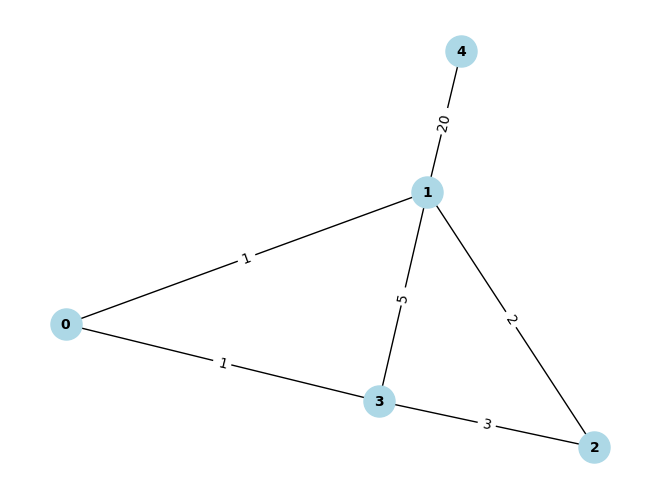

In [3]:
ut.draw_graph(G)

The MaxCut problem aims to determine how to partition (or "cut") the vertices of a graph into two disjoint subsets such that the sum of the weights of the edges crossing between the subsets is maximized.

For this graph, the maxcut bitstring is [1, 0, 0, 1, 1]

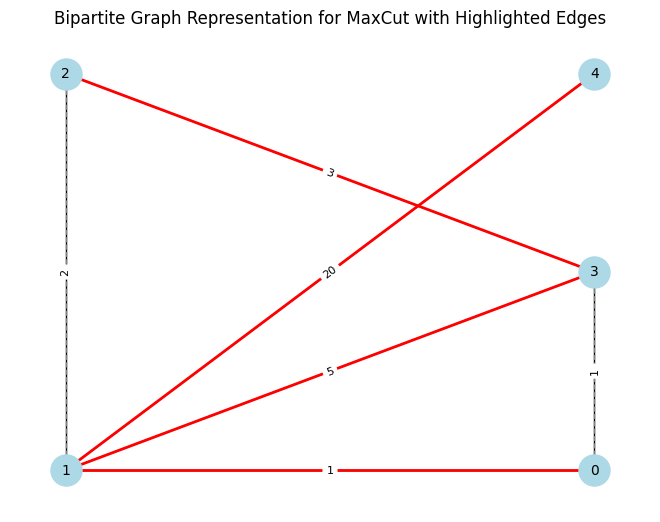

In [4]:
bitstring = [1, 0, 0, 1, 1]
ut.draw_partition_graph(G, bitstring)

So the final answer for maxcut is 29

<h1 style="font-size:3em; "> Tranform to QUBO </h1>

To generalize, Mathematical Formulation

# MaxCut Problem Formulation

Given an undirected graph $G = (V, E)$ with edge weights $w_{ij}$ for $(i, j) \in E$, the MaxCut problem can be formulated as:

$$
\text{Maximize: } \frac{1}{2} \sum_{(i, j) \in E} w_{ij} (1 - x_i x_j)
$$

**Subject to:**

$$
x_i \in \{-1, 1\} \quad \forall i \in V
$$

**Where:**

- $x_i \in \{-1, 1\}$: Indicates the set to which vertex $i$ belongs.
  - $x_i = 1$: Vertex $i$ is in one partition.
  - $x_i = -1$: Vertex $i$ is in the other partition.
- $w_{ij}$: The weight of the edge between vertices $i$ and $j$.


# QUBO Formulation for MaxCut

The **Quadratic Unconstrained Binary Optimization (QUBO)** formulation for the MaxCut problem can be described as follows:

Given an undirected graph $G = (V, E)$ with edge weights $w_{ij}$, the goal is to partition the vertices $V$ into two disjoint subsets $S$ and $T$ such that the weight of the cut is maximized.

### Variables
- Let $x_i \in \{0, 1\}$ for each vertex $i \in V$:
  - $x_i = 0$: Vertex $i$ is in one subset.
  - $x_i = 1$: Vertex $i$ is in the other subset.

### Objective Function
The objective function can be written as:

$$
\text{Maximize: } \sum_{(i, j) \in E} w_{ij} \, x_i (1 - x_j) + w_{ij} \, x_j (1 - x_i)
$$

This simplifies to:

$$
\text{Maximize: } \sum_{(i, j) \in E} w_{ij} \, x_i x_j - \frac{1}{2} \sum_{(i, j) \in E} w_{ij}.
$$

### QUBO Matrix Form
In QUBO, we minimize an energy function represented as:

$$
\text{Minimize: } H(x) = x^T Q x
$$

Where:
- $Q$ is the QUBO matrix,
- $x$ is the vector of binary variables.

For MaxCut:

$$
Q_{ij} =
\begin{cases}
-w_{ij} & \text{if } (i, j) \in E, \\
\sum_{(i, k) \in E} w_{ik} & \text{if } i = j, \\
0 & \text{otherwise.}
\end{cases}
$$

### Example 1

For a simple graph:

- **Graph:** $G = (V, E)$ with:
  - $V = \{1, 2, 3\}$,
  - $E = \{(1, 2), (2, 3)\}$,
  - Weights: $w_{12} = 3$, $w_{23} = 2$.



In [5]:
n = 3
G = nx.Graph()
V = range(1, n+1)
G.add_nodes_from(V)
E = [(1, 2, 3), (2, 3, 2)]
G.add_weighted_edges_from(E)

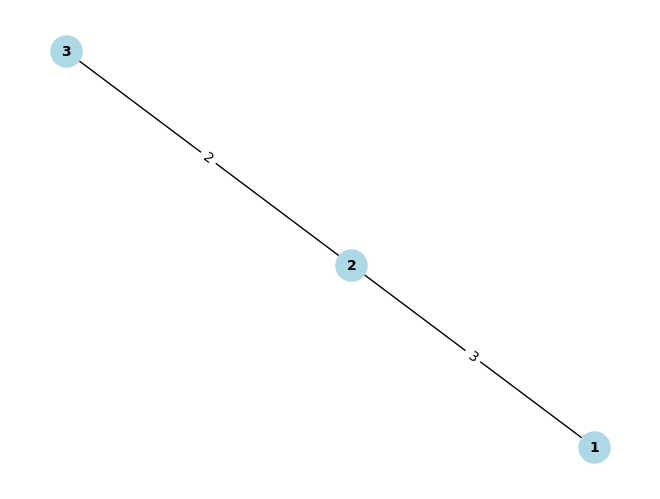

In [6]:
ut.draw_graph(G)

The QUBO matrix $Q$ is:

$$
Q =
\begin{bmatrix}
3 & -3 & 0 \\
-3 & 5 & -2 \\
0 & -2 & 2
\end{bmatrix}.
$$

There are useful function for tranform graph to QUBO

In [7]:
from qiskit_optimization.applications import Maxcut

For good understanding, I recommend to read white paper in resource "problem-formulation-guide.pdf"

First, let make adjacency matrix

In [8]:
w = nx.adjacency_matrix(G).todense()
print(w)

[[0 3 0]
 [3 0 2]
 [0 2 0]]


In [9]:
max_cut = Maxcut(w) #maka max_cut object
qp = max_cut.to_quadratic_program() #make QUBO

print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -6*x_0*x_1 - 4*x_1*x_2 + 3*x_0 + 5*x_1 + 2*x_2

Subject to
  No constraints

  Binary variables (3)
    x_0 x_1 x_2



For Quadratic part

In [10]:
Quadratic = qp.objective.quadratic.to_array()
print(Quadratic)

[[ 0. -6.  0.]
 [ 0.  0. -4.]
 [ 0.  0.  0.]]


For Linear part

In [11]:
Linear = qp.objective.linear.to_array()
print(Linear)

[3. 5. 2.]


Therefore, the QUBO for this graph

In [12]:
print(ut.get_QUBO_Matrix(G))

[[ 3. -6.  0.]
 [ 0.  5. -4.]
 [ 0.  0.  2.]]


### Example 2

For a simple graph:

- **Graph:** $G = (V, E)$ with:
  - $V = \{0, 1, 2, 3, 4\}$,
  - $E = \{(0, 1), (1, 2), (2, 3), (0, 3), (1, 3), (1, 4)\}$,
  - Weights: $w_{01} = 1$, $w_{12} = 2$, $w_{23} = 3$, $w_{03} = 1$, $w_{13} = 5$, $w_{14} = 20$.

In [13]:
n = 5
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 0, 1), (1, 3, 5),(1, 4, 20)]
G.add_weighted_edges_from(E)

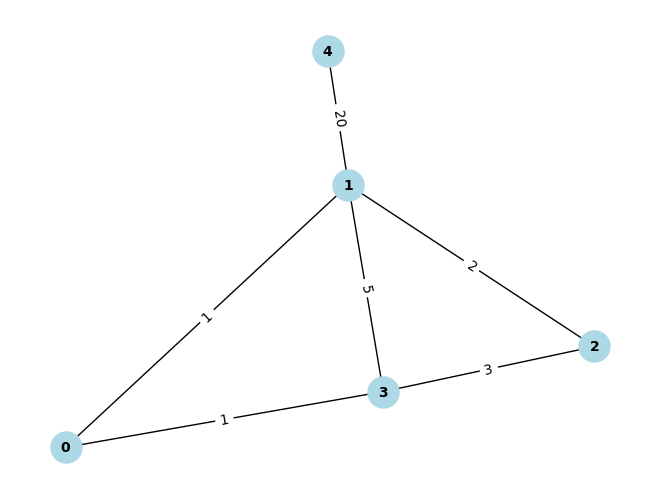

In [14]:
ut.draw_graph(G)

In [15]:
w = nx.adjacency_matrix(G).todense()
print(w)

[[ 0  1  0  1  0]
 [ 1  0  2  5 20]
 [ 0  2  0  3  0]
 [ 1  5  3  0  0]
 [ 0 20  0  0  0]]


In [16]:
max_cut = Maxcut(w) #maka max_cut object
qp = max_cut.to_quadratic_program() #make QUBO

print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 4*x_1*x_2 - 10*x_1*x_3 - 40*x_1*x_4 - 6*x_2*x_3
  + 2*x_0 + 28*x_1 + 5*x_2 + 9*x_3 + 20*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



In [17]:
print(ut.get_QUBO_Matrix(G))

[[  2.  -2.   0.  -2.   0.]
 [  0.  28.  -4. -10. -40.]
 [  0.   0.   5.  -6.   0.]
 [  0.   0.   0.   9.   0.]
 [  0.   0.   0.   0.  20.]]


<h1 style="font-size:3em; "> Solve Problem </h1>
For now, we will use the graph from Example 2 to demonstrate how to solve the problem with each solver.

We will discuss scaling the problem later.

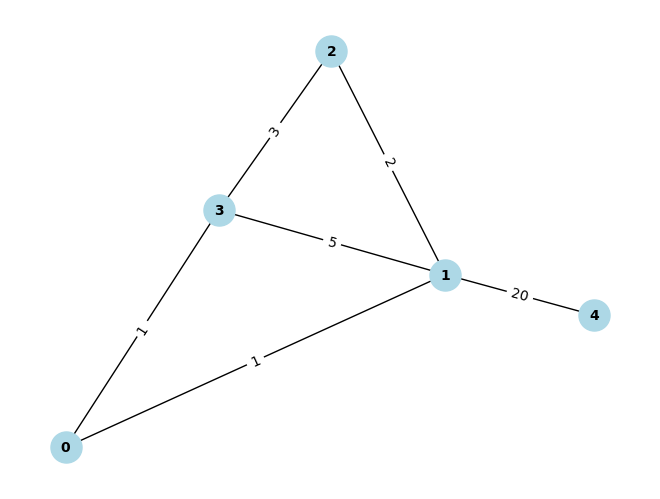

In [18]:
n = 5
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 0, 1), (1, 3, 5),(1, 4, 20)]
G.add_weighted_edges_from(E)
ut.draw_graph(G)

First, we will solve with classical optimizer

### Gurobi

In [19]:
Q = ut.get_QUBO_Matrix(G)
print(Q)

[[  2.  -2.   0.  -2.   0.]
 [  0.  28.  -4. -10. -40.]
 [  0.   0.   5.  -6.   0.]
 [  0.   0.   0.   9.   0.]
 [  0.   0.   0.   0.  20.]]


In [20]:
from gurobi_optimods.qubo import solve_qubo

In [21]:
result = solve_qubo(-Q, solver_params={'MIPGap': 0.01})
print(result.objective_value)
print(result.solution)

New QUBO solution found with objective 0.0
New QUBO solution found with objective -29.0
-29.0
[1. 0. 0. 1. 1.]


### Fixstar

For Fixstar, we need to construct Qudratic part and Linear part seperately

In [22]:
w = nx.adjacency_matrix(G).todense()
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
Quadratic = qp.objective.quadratic.to_array()
Linear = qp.objective.linear.to_array()

Import Fixstar from Amplify

In [23]:
from amplify import FixstarsClient, solve, VariableGenerator
from datetime import timedelta

Get key token for Amplify

In [24]:
from dotenv import load_dotenv
import os

load_dotenv()
FIXSTAR_TOKEN = os.getenv("FIXSTAR_TOKEN")

In [25]:
client = FixstarsClient()
client.token = FIXSTAR_TOKEN
client.parameters.timeout = timedelta(milliseconds=1000)
client.parameters.outputs.num_outputs = 0

Construct Module. For detail https://amplify.fixstars.com/en/docs/amplify/v1/index.html

In [26]:
gen = VariableGenerator()
m = gen.matrix("Binary", n)
m.quadratic = -Quadratic
m.linear = -Linear
result = solve(m, client)

In [27]:
print("execution time : " + str(result.execution_time))
q = m.variable_array
print(f"solution : {q.evaluate(result.best.values)}")
print(f"objective = {-result.best.objective}")
print(m)

execution time : 0:00:00.950572
solution : [0. 1. 1. 0. 0.]
objective = 29.0
(x^T) Q x + (p^T) x + c
where:
  x = [q_0, q_1, q_2, q_3, q_4],
  Q = [[ -0.,   2.,  -0.,   2.,  -0.],
       [ -0.,  -0.,   4.,  10.,  40.],
       [ -0.,  -0.,  -0.,   6.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.]],
  p = [ -2., -28.,  -5.,  -9., -20.],
  c = 0


Note that, there are several solutions to get best objective value (29)

#### Next we will solve problem with Quantum Computer simulater

### Qiskit

In [28]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
print(qubitOp)

SparsePauliOp(['IIIZZ', 'IZIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  1. +0.j,  2.5+0.j, 10. +0.j,  1.5+0.j])


We will solve problem with [QAOA](https://arxiv.org/pdf/1411.4028)

In [29]:
from qiskit.circuit.library import QAOAAnsatz
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler

In [30]:
reps = 1
circuit = QAOAAnsatz(cost_operator=qubitOp, reps=reps)

pm = generate_preset_pass_manager(optimization_level=3)
candidate_circuit = pm.run(circuit)

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = []
for _ in range(reps):
    init_params.extend([initial_gamma, initial_beta])

Let define Objective function value

In [31]:
objective_func_vals = []
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost

In [32]:
estimator = Estimator()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, qubitOp, estimator),
    method="COBYLA",
    tol=1e-3,
    options={'disp': True}
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.2053523530747308
       x: [ 3.556e+00  2.775e+00]
    nfev: 63
   maxcv: 0.0


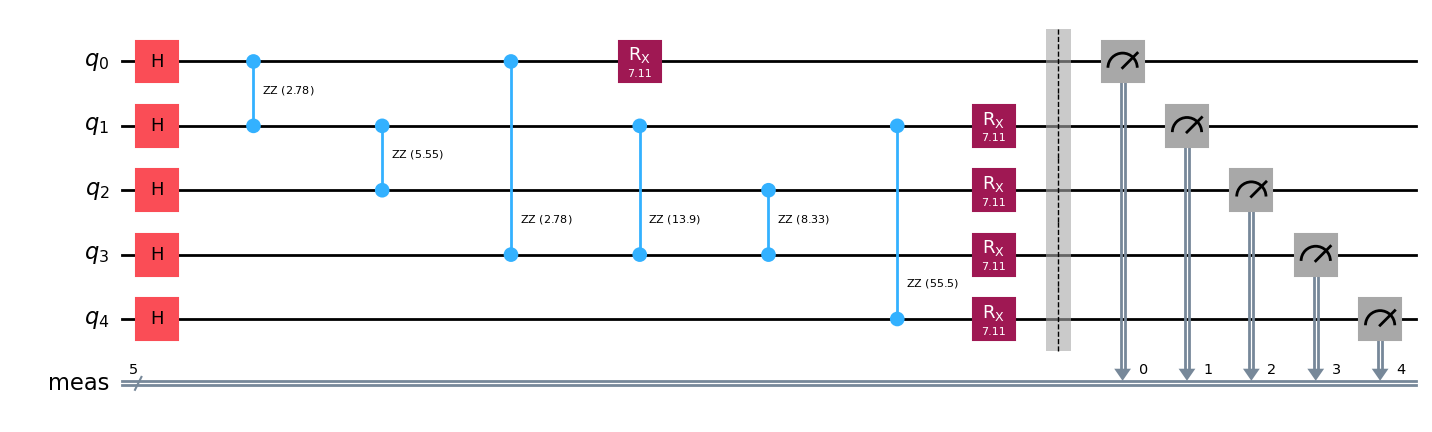

In [33]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [34]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

In [35]:
sampler = Sampler() 

pub = (optimized_circuit, )

job = sampler.run([pub], shots=1024)
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{14: 0.126953125, 17: 0.1103515625, 28: 0.0673828125, 2: 0.0498046875, 13: 0.03125, 25: 0.0126953125, 22: 0.0087890625, 8: 0.01953125, 12: 0.05078125, 18: 0.029296875, 15: 0.0322265625, 7: 0.037109375, 29: 0.056640625, 30: 0.013671875, 16: 0.03125, 3: 0.0654296875, 24: 0.0302734375, 0: 0.0068359375, 11: 0.01953125, 19: 0.0625, 10: 0.0244140625, 9: 0.01171875, 26: 0.0029296875, 1: 0.0166015625, 21: 0.0146484375, 23: 0.013671875, 6: 0.0107421875, 20: 0.0166015625, 31: 0.01171875, 27: 0.0087890625, 4: 0.00390625, 5: 0.001953125}


In [36]:
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, 5)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 1, 0]


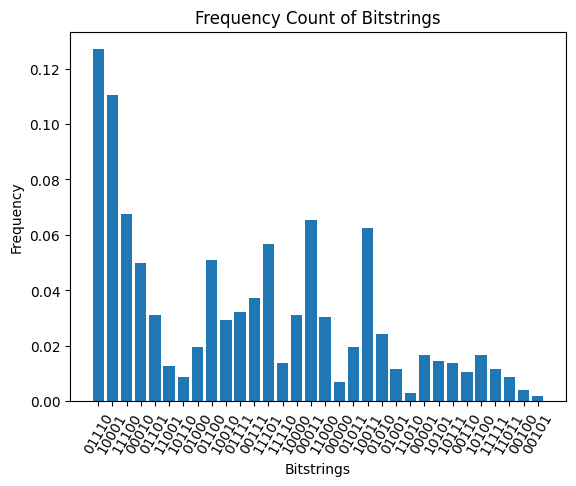

In [37]:
def plot_frequency_count(bitstring_counts):
    # Extract the bitstrings and their corresponding frequencies
    bitstrings = list(bitstring_counts.keys())
    frequencies = list(bitstring_counts.values())

    # Create a bar chart
    plt.bar(bitstrings, frequencies)
    plt.xlabel('Bitstrings')
    plt.ylabel('Frequency')
    plt.title('Frequency Count of Bitstrings')
    plt.xticks(rotation=60)
    plt.show()

plot_frequency_count(final_distribution_bin)

You will see that there are many solution in the distribution, and the most frequency bit strings isn't the best solution.

TODO: Discuss why qiskit's QAOA doesn't converge to ideal answer (29) and how to improve it to give the better answer.

### D-Wave

In [38]:
w = nx.adjacency_matrix(G).todense()
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
Quadratic = qp.objective.quadratic.to_array()
Linear = qp.objective.linear.to_array()

Import DWave from Amplify

In [39]:
from amplify import DWaveSamplerClient

Get DWAVE TOKEN from .env

In [ ]:
DWAVE_TOKEN = os.getenv("DWAVE_TOKEN")
client = DWaveSamplerClient()
client.token = DWAVE_TOKEN
client.parameters.num_reads = 1000

In [ ]:
gen = VariableGenerator()
m = gen.matrix("Binary", n)
m.quadratic = -Quadratic
m.linear = -Linear
result = solve(m, client)

In [ ]:
print("execution time : " + str(result.execution_time))
q = m.variable_array
print(f"solution : {q.evaluate(result.best.values)}")
print(f"objective = {-result.best.objective}")
print(m)

execution time : 0:00:00.139881
solution : [0. 0. 0. 1. 1.]
objective = 29.0
(x^T) Q x + (p^T) x + c
where:
  x = [q_0, q_1, q_2, q_3, q_4],
  Q = [[ -0.,   2.,  -0.,   2.,  -0.],
       [ -0.,  -0.,   4.,  10.,  40.],
       [ -0.,  -0.,  -0.,   6.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.]],
  p = [ -2., -28.,  -5.,  -9., -20.],
  c = 0
